# PA005: High Value Customer Identification (Insiders)

## 0.0 Planejamento da solução (IOT)

### Input - Entrada

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização

2. Conjunto de dados
    - Vendas de um e-commerce durante o perído de um ano.

### Output - Saída

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider
                2930   |   yes/1
                3492   |   no/1

2. Relatório com as respostas das perguntas de negócio
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?
                

### Task - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento:
        - Alto Ticket médio. (média dos gastos na empresa)
        - Alto LTV. (Total gasto na empresa)
        - Baixa Recência. (intervalo entre as compras)
        - Alto basket size. (itens comprados de 1 vez) - Talvez seja redundante em relação às outras métricas
        - Baixa probabilidade de Churn. (chance de deixar de consumir produtos da empresa) -  Comum rodar um modelo de churn e           usar o resultado como coluna na clusterização
        - Alta previsão de LTV.
        - Alta propensão de compra.
        
    - Custo:
        - Baixa taxa de devolução.
        
    - Experiência:
        - Média alta das avaliações.
        
    
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo Insiders
    

3. Quais as principais características desses clientes?
    - Escrever características do cliente: 
        - Idade
        - Localização
        
    - Escrever características do consumo.
        - Atributos da clusterização. 
        

4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    

5. Qual a expectativa de faturamento desse grupo para os próximos meses? (Ex: Assumir essa métrica no planejamento do orçamento da empresa)
    - LTV do grupo Insiders
    - Análise de Cohort. (Marcação em relação a algo e acompanhamento do desempenho)
    

6. Quais as condições para uma pessoa ser elegível ao Insiders?
    - Definir a periodicidade. (1 mês, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo.

7. Quais as condições para uma pessoa ser removida do Insiders?
    - Definir a periodicidade. (1 mês, 3 meses)
    - A pessoa precisa ser desimilar ou não-parecido com uma pessoa do grupo.


8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Teste A/B.
    - Teste A/B Bayesiano.
    - Teste de hipóteses.
     

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frete
    - Visita a empresa




## Benchmark de soluções
### 1. Desk Research

# 0.0 Imports

In [49]:
import inflection
import numpy   as np
import pandas  as pd
import seaborn as sns
import umap.umap_ as umap

from matplotlib import pyplot as plt
from IPython.display import HTML

from pandas_profiling import ProfileReport

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import decomposition as dd
from sklearn.manifold import TSNE
from sklearn import ensemble as en
from sklearn import preprocessing as pp

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Load dataset

In [3]:
#load data
df = pd.read_csv('data/Ecommerce.csv', encoding='unicode_escape')

#drop extra column
df = df.drop(columns=['Unnamed: 8'], axis=1)

In [4]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

# 1.0 Descrição dos dados

In [4]:
df1 = df.copy()

## 1.1 Rename Columns

In [5]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
            'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [6]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Columns: 8


## 1.3 Data Types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [8]:
# invoice_no são números. Como está dando object, deve haver algum caractere em algum lugar
# Usar o código abaixo para descobrir onde está;

#df1['invoice_no'] = df1['invoice_no'].astype(int)

## 1.4 Check NA

In [9]:
df1.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [10]:
#Separar os Dados com NA
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [11]:
df_not_missing.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [12]:
#Teste para identificar se os invoice_no correspondem em ambos os df's. Nesse caso, não há correspondência. Será necessária outra estratégia.
missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()
df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice), :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


In [13]:
#Verificar o valor máximo do 'customer_id'
df_not_missing['customer_id'].max()

18287.0

In [14]:
#Para não perder os dados, atribuir valores de 'customer_id' para os 'invoice_no' do df com NA's. Usar esses dados para treinar o algoritmo e retira-los ao final da modelagem.
#Create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

#Coalesce
## Come foram geradas duas colunas e ambas possuem NA's, será necessário usar artifício para combinar as colunas 
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

#drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [15]:
df1.isnull().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change Dtypes

In [16]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [17]:
#invoice_no e stock_code serão analisados posteriormente

#invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

#customer_id
df1['customer_id'] = df1['customer_id'].astype('int64')

In [18]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Statistics

In [19]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [20]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenar
m1 = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### <font color='red'>1.7.1.1 Numerical Attributes - Investigating </font>

1. Quantity negativa (pode ser devolução)

2. Preço unitário igual a zero (pode ser promoção?)


### 1.7.2 Categorical Attributes

In [21]:
#invoice_no

#cat_attributes['invoice_no'].astype(int) - #Algumas strings entre os números
#len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search( '[^0-9]+', x ))), 'invoice_no'].drop_duplicates())

df_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search( '[^0-9]+', x ))), :]

print('Total number of invoices: {}'.format(len(df_invoices)))
print('Total number of negative quantity: {}'.format(len(df_invoices[df_invoices['quantity'] < 0])))

Total number of invoices: 9291
Total number of negative quantity: 9288


In [22]:
#stock_code
#aux = len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search( '[^0-9]+', x))), 'stock_code'].drop_duplicates())

#cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search( '^[a-zA-Z]+$', x))), 'stock_code'].unique()
#df1.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search( '^[a-zA-Z]$', x ))), :].head()

df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

#Ação:
## 1. Remove stock_code in ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

### Description

In [23]:
df1.head()

#Ação: Delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


### Country

In [24]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [25]:
df1['country'].value_counts(normalize=True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [26]:
#Drop_duplicates é usado quando quero saber o número de usuários únicos. Sem o drop a granularidade é por compra. Ex: 1 usuário pode ter feito 10 compras
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0 Filtragem de Variáveis

- Nesse caso a filtragem se fez necessária antes do passo 2 pq no passo 2 são feitos cálculos pra criar as variáveis, logo, n pode haver sujeira. Isso justifica adiantar o passo 3

In [27]:
df2 = df1.copy()

In [28]:
# Numerical Attributes

## Separar entre dados com devoluções e sem devoluções
df2 = df2.loc[df2['unit_price'] >= 0.04, :]


# -- Categorical Attributes --

#isin pq fica mais fácil já que é uma lista | ~ (usado com o isin) pq vou pegar oq não estiver contido na condição
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])] 

#description
df2 = df2.drop(columns='description', axis=1)

#map 
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

#bad users
df2 = df2[~df2['customer_id'].isin([16446])]

#quantity
df2_charge_back = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] >= 0, :]


In [29]:
#df3.loc[df3['unit_price'] > 0.04 , ['customer_id', 'description', 'unit_price']].sort_values('unit_price', ascending=True).head(10)

# 3.0 Feature Engeneering

In [30]:
df3 = df2.copy()

## 3.1 Feature Creation

In [31]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date',
                   'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

- Ficar atento pq Meiga não usou o purchases pra fazer o df_ref

### 3.1.1 Gross Revenue

In [32]:
#Gross Revenue (Faturamento) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

#Monetary
df_monetary = df2_purchases.loc[: ,['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

C:\Users\Ed\AppData\Local\Temp\ipykernel_9720\1095068563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


### 3.1.2 Recency

In [33]:
#Recency - Last day purchase - Como o dataset é antigo, usar como date o último invoice_date
df_recency = df2_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index() # Agrupa por usuários e pega a data máxima da última compra de cada
df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

### 3.1.3 Quantity purchases

In [34]:
#Numero de compras no ano
df_frequency = df2_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'qtd_invoices'})
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')

### 3.1.4 Quantity of items purchased

In [35]:
#Número de produtos comprados
## Com o drop_duplicates os valores de quantity que fossem iguais estavam sendo descartados, gerando incongruência nos dados.
#df_frequency = df2_purchases[['customer_id', 'quantity']].drop_duplicates().groupby('customer_id').count().reset_index()

df_frequency = df2_purchases[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtd_items'})
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')

### 3.1.4 Quantity type of items purchased

In [36]:
df_frequency = df2_purchases[['customer_id','stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code': 'qtd_products'})
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')

### 3.1.5 Average Ticket Value

In [37]:
#AVG Ticket
df_avg_ticket = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left') #Sempre calcular os NA's depois do left join
df_ref.isnull().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtd_invoices     91
qtd_items        91
qtd_products     91
avg_ticket       91
dtype: int64

### 3.1.6 Average Recency Days

In [38]:
#Descobrir a diferença de dias entre as datas das compras
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # 'shift' desloca a coluna selecionada para 1 linha abaixo
df_aux['previous_date'] = df_aux['invoice_date'].shift()

#Com as colunas deslocadas, é possível fazer uma subtração na mesma linha
df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis =1) #'axis=1' pra + 2 colun

#Dropa as colunas que n vão ser usadas e as linhas que contiverem NA's
df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

#Average recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

#merge

df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtd_invoices          91
qtd_items             91
qtd_products          91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.7 Frequency Purchase

In [39]:
#Pegar a data máxima, mínima, subtrair e dividir pela quantidade de compras
df2_max = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').max().reset_index()
df2_min = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').min().reset_index()
df2_purchase = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').count().reset_index()


In [40]:
#Função agregate (nome da coluna, coluna que será utilizada, operação nessa coluna)
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id')
                                                                     .agg(max_ = ('invoice_date', 'max'), #Apenas para melhorar a visualização, pois o cálculo é feito em "days_"
                                                                          min_ = ('invoice_date', 'min'),
                                                                          days_= ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                          buy_ = ('invoice_no', 'count'))).reset_index()

#Calculate Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

#merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtd_invoices          91
qtd_items             91
qtd_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.8 Devoluções

In [41]:
df_returns = df2_charge_back[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtd_returns'})
df_returns['qtd_returns'] = df_returns['qtd_returns'] * -1

#merge
df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')

#Substituir NA's returns por 0
df_ref.loc[df_ref['qtd_returns'].isna(), 'qtd_returns'] = 0
#df_ref['qtd_returns'].fillna(0, inplace = True)

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtd_invoices          91
qtd_items             91
qtd_products          91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtd_returns            0
dtype: int64

### 3.1.9 Basket Size

In [42]:
#Criação de duas colunas: número de compras e quantidade total de produtos por usuário
df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                 .agg(n_purchase=('invoice_no', 'nunique'),
                                                                      n_products=('quantity', 'sum')).reset_index())

#Cálculo da média de itens por compras
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

#merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], on='customer_id', how='left')

### 3.1.10 Unique Basket Size - Quantidade de produtos distintos por compra

In [43]:
#Criação de duas colunas: número de compras e produtos distintos por usuário
df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                 .agg(n_purchases=('invoice_no', 'nunique'),
                                                                      n_stock_code=('stock_code', 'nunique')).reset_index())

#Cálculo da média de itens distintos por compras
df_aux['avg_unique_basket_size'] = df_aux['n_stock_code'] / df_aux['n_purchases']


#merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], on='customer_id', how='left')

In [44]:
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtd_invoices                91
qtd_items                   91
qtd_products                91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtd_returns                  0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4.0 EDA (Exploratory Data Analysis)

In [45]:
df4 = df_ref.dropna()
df4.isnull().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtd_invoices              0
qtd_items                 0
qtd_products              0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtd_returns               0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 Univariate Analysis

1. Clusterização: Coeso e afastado.
- Nem sempre essa métrica pode ser alcançada, pois existem problemas que pelo próprio negócio inviabilizam.
- E-commerce tradicional 
2. Métricas (variabilidade)
    - Min, Máx, Range(Dispersão)
    - Média e Mediana (Se estiverem iguais, não há outliers. Nesse caso é melhor que tenha)
    - Desvio Padrão e Variância (Média da distância dos pontos até o centro. Se for alto, os pontos estão distantes)
    - Coeficiente de Variação (STD/Média. Nesse caso, quanto maior, melhor, pois indica variação e pra clusterização é bom)
    - Distribuição

**Investigar/Remover**

1. Gross Revenue - ok

In [116]:
profile = ProfileReport(df4)
profile.to_file('output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 4.1.1 Gross Revenue

In [117]:
#Analisar para identificar se o alto valor de gross revenue é um outlier
df4.sort_values('gross_revenue', ascending=False).head(10)

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.203390,288.0,2733.944444,9.708333
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,14.680000,0.163043,0.0,1068.733333,2.500000
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,12.821429,0.127778,952.0,1521.586957,2.695652
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,2.601399,0.533512,3332.0,403.331658,8.974874
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.704811,20.866667,0.063694,427.0,3868.650000,22.150000
190,14156,117379.63,9.0,55.0,57885.0,1400.0,83.842593,7.260000,0.151515,859.0,1052.454545,12.981818
15,17511,91062.38,2.0,31.0,64549.0,963.0,94.561142,11.593750,0.083333,1535.0,2082.225806,14.612903
12,16029,72882.09,38.0,62.0,40207.0,241.0,302.415311,9.054054,0.184524,8004.0,648.500000,0.693548
955,16684,66653.56,4.0,28.0,50255.0,277.0,240.626570,22.125000,0.078873,864.0,1794.821429,4.250000
36,13694,65039.62,3.0,50.0,63312.0,568.0,114.506373,9.736842,0.134771,1504.0,1266.240000,7.320000


In [118]:
#Verificar se os valores correspondem aos calculador no passo anterior
#np.sum(df3.loc[df3['customer_id'] == 14646, 'quantity'] * df3.loc[df3['customer_id'] == 14646, 'unit_price'])

#len(df3.loc[df3['customer_id'] == 14646, 'invoice_no'].unique())

#Valor muito incompatível com o calculado anteriormente. Analisando o cálculo na seção anterior, foi detectado um erro.
df3.loc[df3['customer_id'] == 14646, 'quantity'].sum()


196556

### 4.1.2 QTD Products

In [119]:
#Aparentemente normal
df4[df4['qtd_products'] == 7838]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
68,17841,40967.72,1.0,124.0,23053.0,7838.0,5.226808,3.321429,0.33244,203.0,185.91129,10.66129


### 4.1.3 AVG Ticket

In [120]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size


In [149]:
#Esse customer mais atrapalha q ajuda na análise. Será removido.
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,-80995,2017-12-07,2.08,United Kingdom,16446


### 4.1.4 Frequency

In [92]:
df4[df4['frequency'] == 17]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.5,17.0,40.0,50.970588,0.617647


In [94]:
df3[df3['customer_id'] == 17850].head(30)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850
5,536365,22752,2,2016-11-29,7.65,United Kingdom,17850
6,536365,21730,6,2016-11-29,4.25,United Kingdom,17850
7,536366,22633,6,2016-11-29,1.85,United Kingdom,17850
8,536366,22632,6,2016-11-29,1.85,United Kingdom,17850
47,536372,22632,6,2016-11-29,1.85,United Kingdom,17850


### 4.1.5 AVG Basket Size

In [96]:
df4[df4['avg_basket_size'] == 40498.5]

,customer_id,gross_revenue,recency_days,qtd_invoices,qtd_items,qtd_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
3338,16446,168472.5,0.0,2.0,80997.0,3.0,56157.5,205.0,0.009709,80995.0,40498.5,1.5


## 4.2 Bivariate Analysis

In [121]:
cols = ['customer_id']
df42 = df4.drop(cols, axis = 1)

<Figure size 1800x864 with 0 Axes>

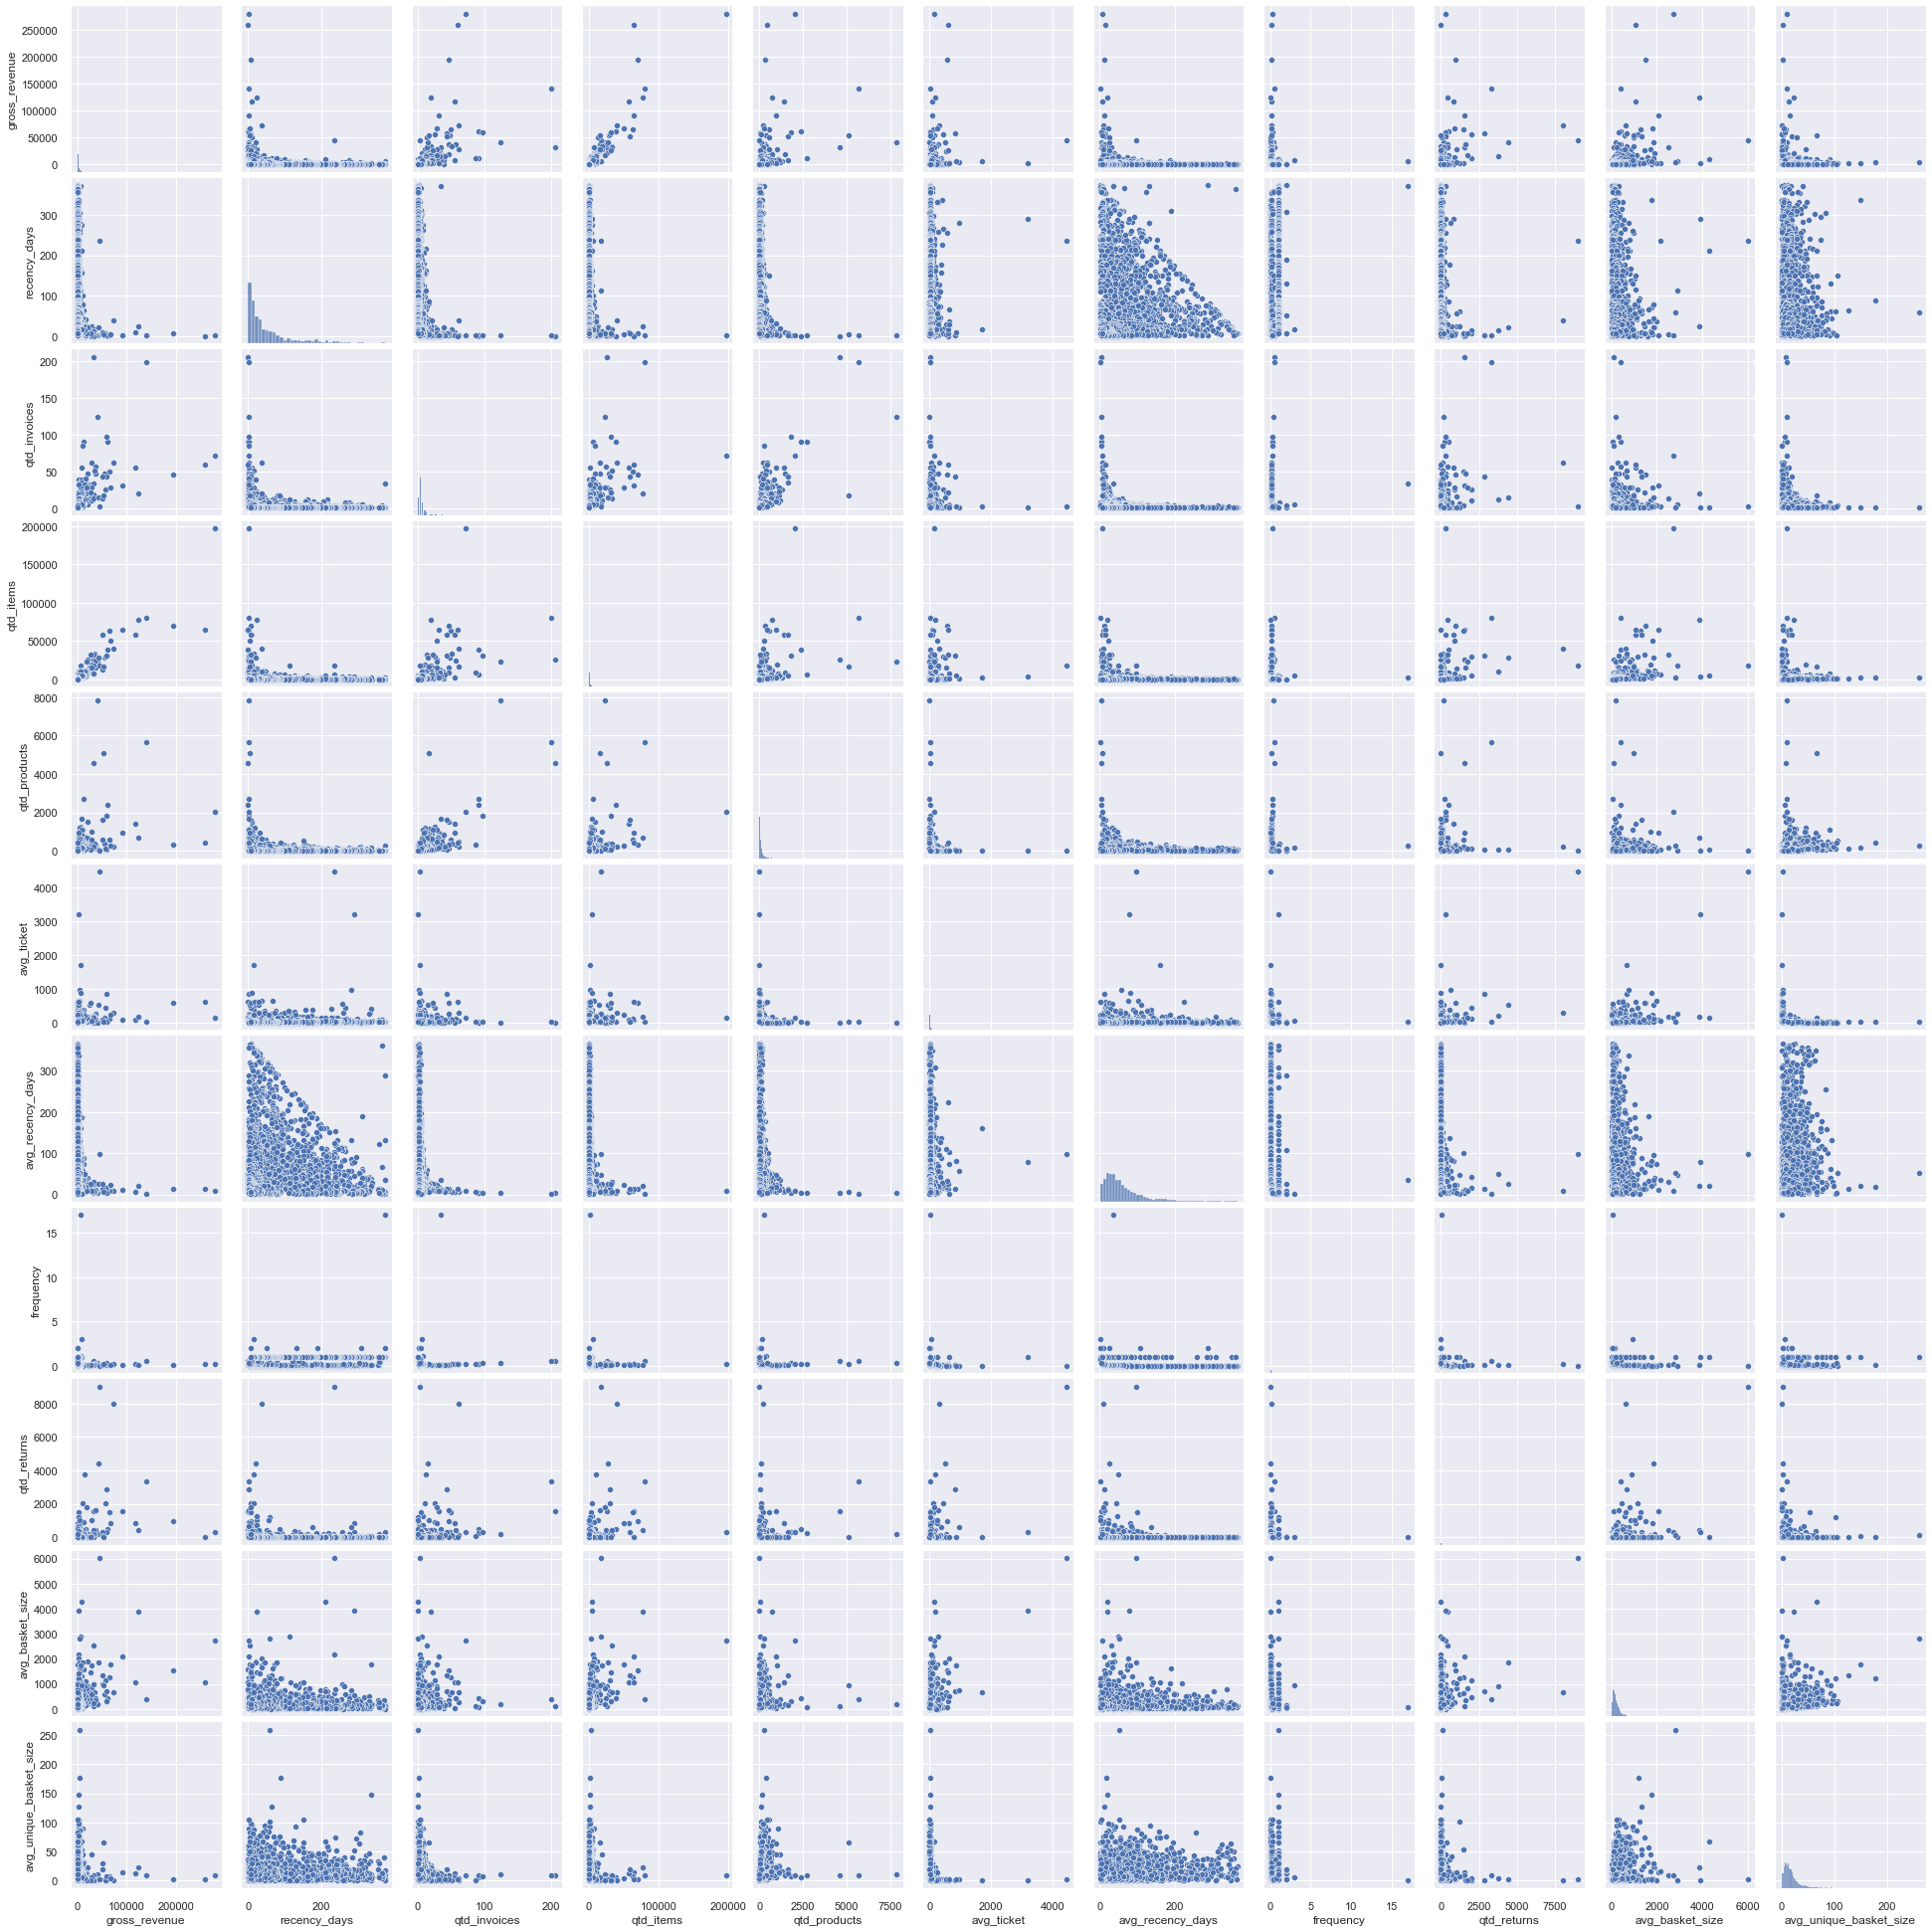

In [122]:
plt.figure(figsize=(25,12))
sns.pairplot(df42)

**Notas**

1. Frequency has low variance
2. AVG Ticket has low variance

## 4.3 Estudo do Espaço

In [123]:
df43 = df4.drop(columns=['customer_id'], axis=1).copy()

In [124]:
from sklearn import preprocessing as pp

In [125]:
mm = pp.MinMaxScaler()

#
df43['gross_revenue']          = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days']           = mm.fit_transform(df43[['recency_days']])
df43['qtd_invoices']           = mm.fit_transform(df43[['qtd_invoices']])
df43['qtd_items']              = mm.fit_transform(df43[['qtd_items']])
df43['qtd_products']           = mm.fit_transform(df43[['qtd_products']])
df43['avg_ticket']             = mm.fit_transform(df43[['avg_ticket']])
df43['avg_recency_days']       = mm.fit_transform(df43[['avg_recency_days']])
df43['frequency']              = mm.fit_transform(df43[['frequency']])
df43['qtd_returns']            = mm.fit_transform(df43[['qtd_returns']])
df43['avg_basket_size']        = mm.fit_transform(df43[['avg_basket_size']])
df43['avg_unique_basket_size'] = mm.fit_transform(df43[['avg_unique_basket_size']])

X = df43.copy()

In [126]:
X.shape[1]

11

### 4.3.1 PCA

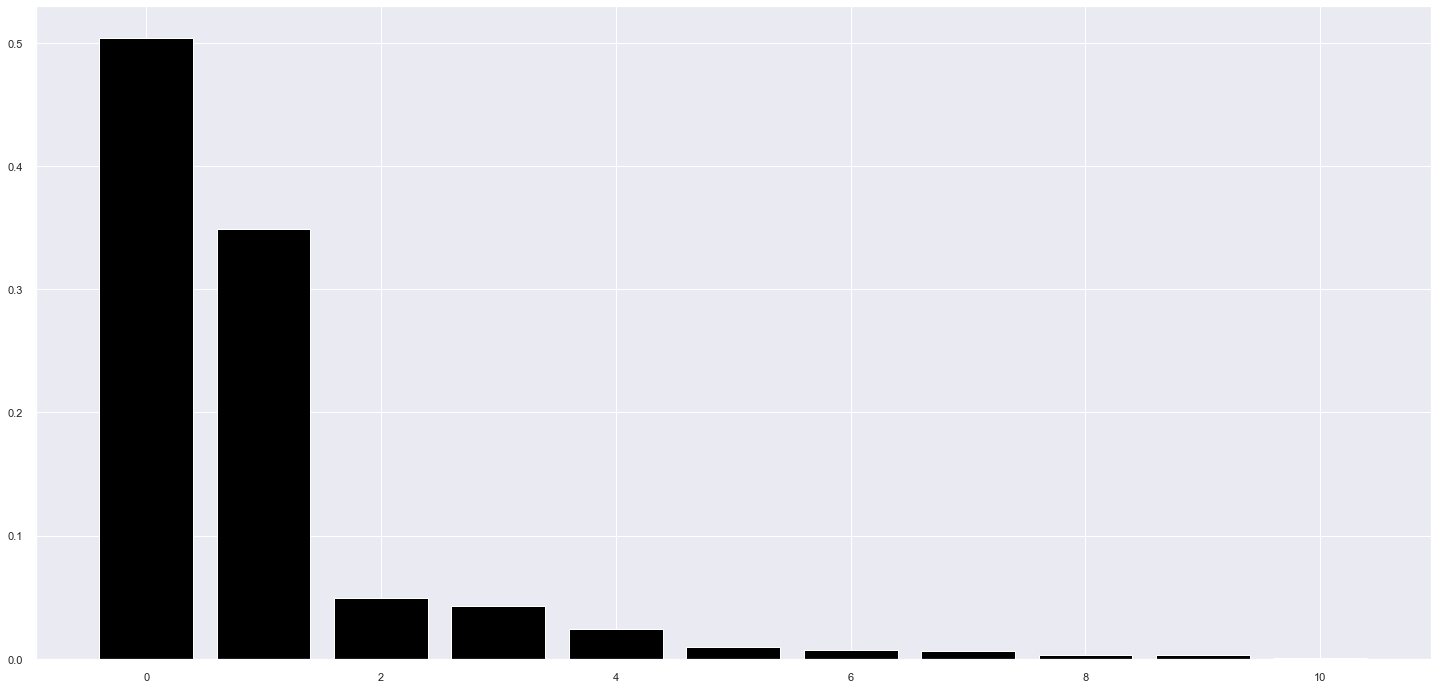

In [127]:
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

#plot explained variable
features= range(pca.n_components)#linhas

plt.bar(features, pca.explained_variance_ratio_, color='black')

#Quant maior as barras, maior a variação

#pca component
df_pca = pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

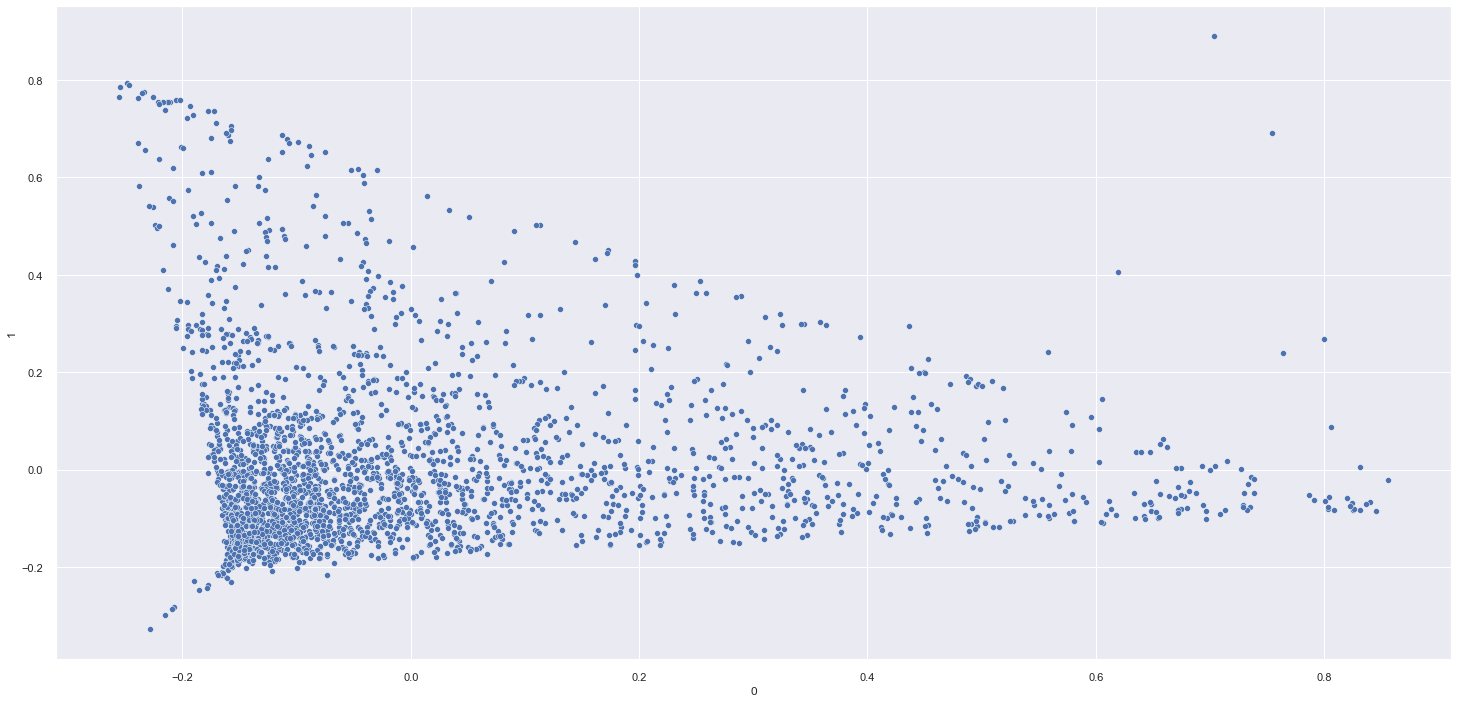

In [128]:
#Escolhendo os components com maior variação
sns.scatterplot(x=0, y=1, data=df_pca)

#Pela análise do gráfico presume-se que esse espaço não é bom, pois não possue divisões claras.

### 4.3.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

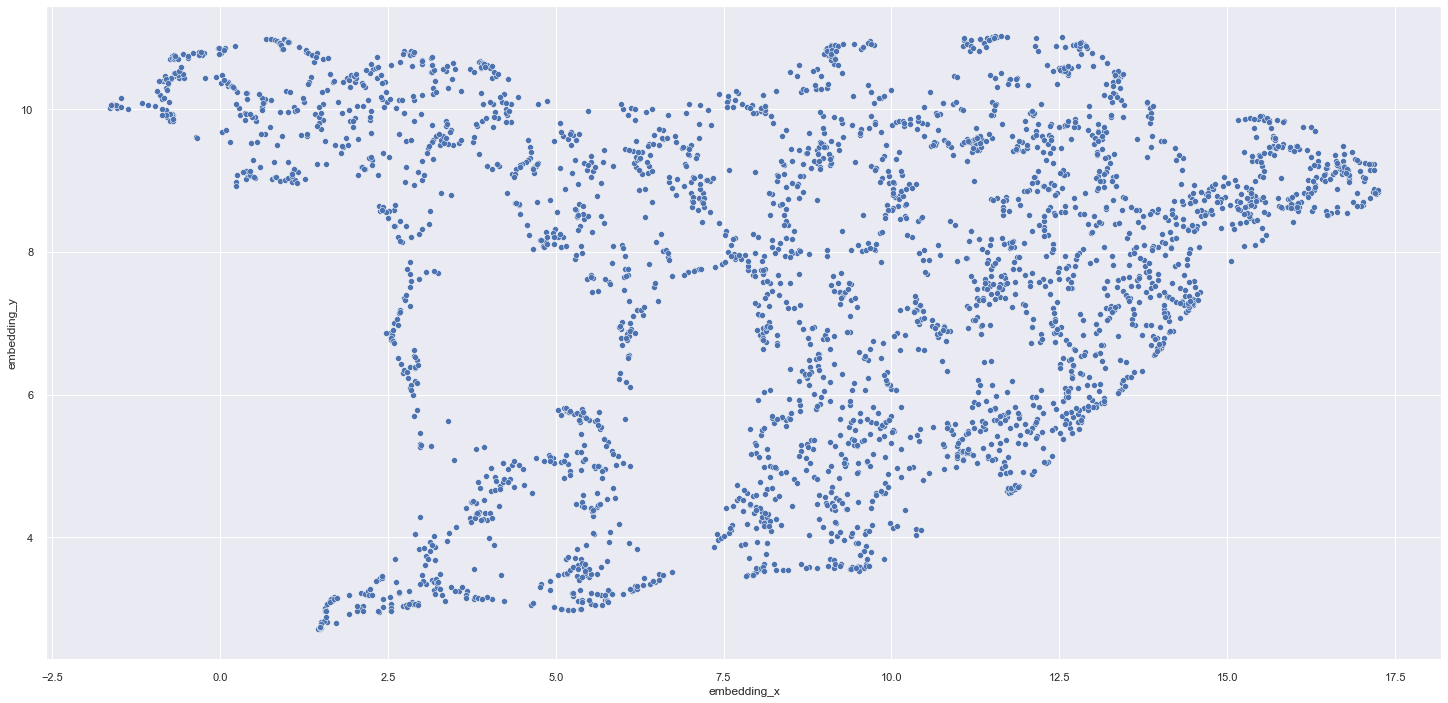

In [129]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)

### 4.3.3 t-SNE

C:\Users\Ed\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Ed\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

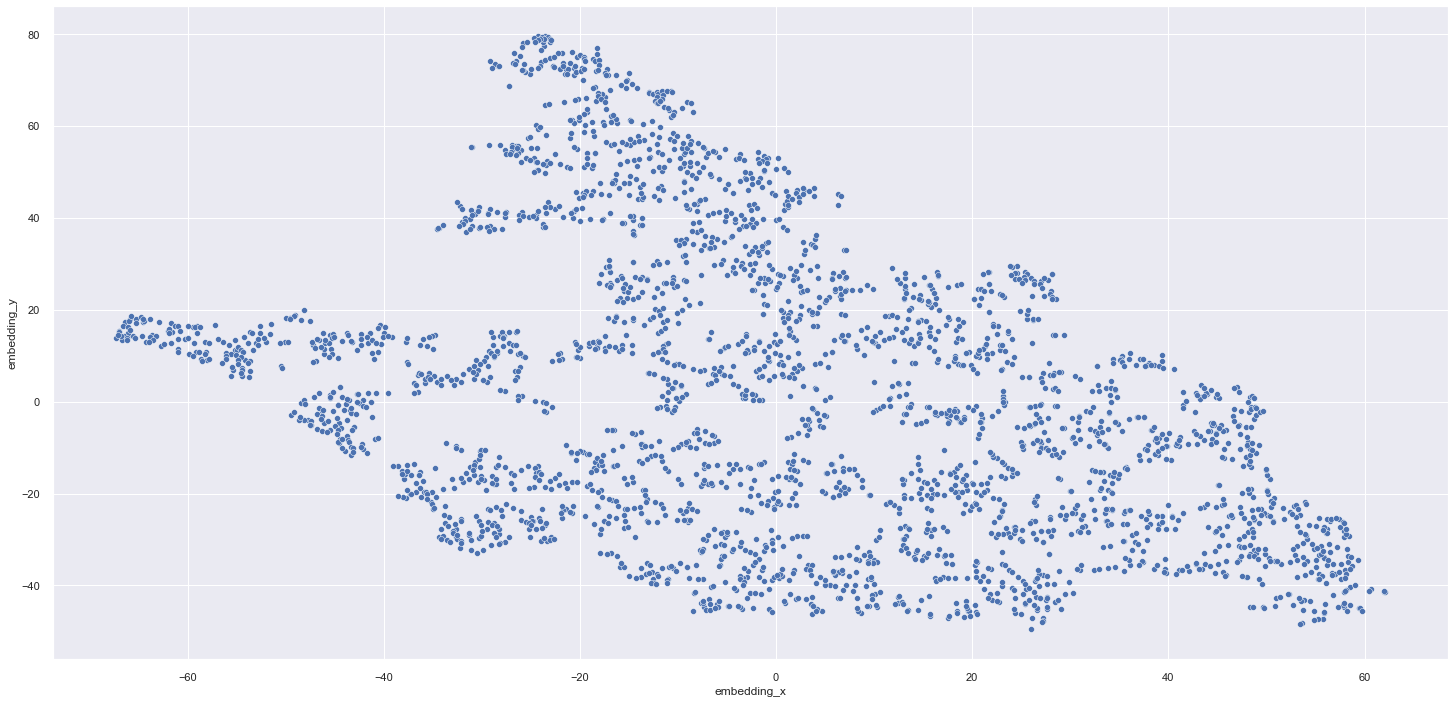

In [130]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_pca)

### 4.3.4 Tree-Based Embedding

In [131]:
#Como o problema é não supervisionado, usei a variável gross revenue para ser a variável resposta, tendo em vista que pra esse problema de negócio esta variável é a mais importante
##Como o problema é de árvore, n é necessário usar os dados com reescala

#training dataset
X = df4.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df4['gross_revenue']

#model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42)

#model training
rf_model.fit(X, y)

#Leaf

#dataframe Leaf

RandomForestRegressor(random_state=42)

In [132]:
#Aplicar os dados de treino sobre a árvore treinada com o objetivo de obter as folhas 
df_leaf = pd.DataFrame(rf_model.apply(X))

In [133]:
#Cada linha representa um customer, e cada coluna representa uma árvore. O valor representa a posição da folha (index d euma lista) que o customer caiu para cada respectiva árvore
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2991,2716,3326,3337,2284,3147,3227,3135,3166,3364,3155,3306,3145,3188,2799,3205,3010,3174,3102,3294,3066,3081,2905,3298,3348,3362,3270,3015,3089,3041,3311,3385,3374,3336,3142,3248,3410,3134,2961,3028,3278,3248,3221,3134,3180,3143,3286,3332,3348,3132,3108,2920,3139,3391,3377,3217,3170,3414,3220,2977,3421,2884,3336,3251,2713,3043,3301,3327,3131,3305,3346,3271,2702,2967,3116,3159,3304,3105,3216,3048,3237,3323,3136,3073,3290,3101,3288,3203,3133,3272,3186,3172,3176,3059,3044,3121,3187,2826,3356,3326
1,2960,2924,3042,2970,2739,3131,2924,2830,3110,2853,3101,2565,2550,3114,2748,3122,2983,3046,3064,2759,2953,3020,2734,2833,3015,2919,2840,2780,3075,3032,2869,3017,2969,2746,2920,2972,2853,2665,3055,3019,2972,2783,3195,3110,3117,2761,2913,2933,2979,3108,3179,3005,3057,2950,2980,2961,3128,3014,2861,2963,2994,2859,2894,2866,2999,3030,2977,2903,3045,2916,2959,2967,3147,2926,3043,2786,2901,3071,3159,3024,2918,2891,2983,2585,2909,3088,2931,3152,3093,2852,2509,2887,2883,2992,3145,3010,2911,2799,2964,2816
2,3632,3608,3587,3411,3570,3660,3634,3548,3679,3614,3627,3579,3545,3652,3563,3567,3583,3654,3551,3463,3513,3638,3604,3525,3571,3646,3575,3603,3589,3719,3432,3674,3595,3635,3574,3614,3547,3521,3597,3483,3654,3403,3633,3509,3535,3600,3425,3649,3633,3548,3630,3503,3567,3612,3683,3631,3610,3644,3570,3568,3617,3589,3582,3689,3456,3620,3652,3493,3552,3621,3590,3427,3575,3605,3543,3559,3598,3563,3537,3494,3436,3458,3566,3427,3531,3597,3583,3710,3601,3563,3598,3440,3560,3482,3601,3460,3528,3619,3568,3654
3,1278,1412,1763,1489,2017,1461,2102,1458,1656,1718,2045,2296,1344,1596,1523,1998,1921,1600,1932,1413,1834,1442,1464,1496,1145,1475,1509,1527,1987,1310,1945,1533,1503,1450,1540,1544,2162,2204,1660,1480,1498,1482,1462,1809,1530,1498,1465,1432,1393,1666,1805,1493,1349,2226,2106,1492,1556,1738,1298,2126,1483,1904,1888,1773,1479,1492,1393,1758,1064,1362,2303,1584,2180,2172,1272,2040,2044,1499,1917,1474,1910,1419,1520,1654,1481,1493,2046,1343,1661,1541,1877,1719,2026,1881,1936,2246,1467,1196,1988,2105
4,355,715,579,691,146,711,734,689,191,197,580,722,665,195,569,612,575,418,549,391,576,709,416,200,629,210,440,206,147,729,703,201,211,202,233,718,595,203,702,972,516,876,217,592,890,674,285,604,691,607,588,184,756,399,80,550,700,666,720,604,231,730,188,206,667,454,474,592,456,202,713,229,549,620,717,199,718,180,108,226,209,696,757,217,682,162,305,726,686,808,331,192,584,544,196,156,189,705,707,175


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

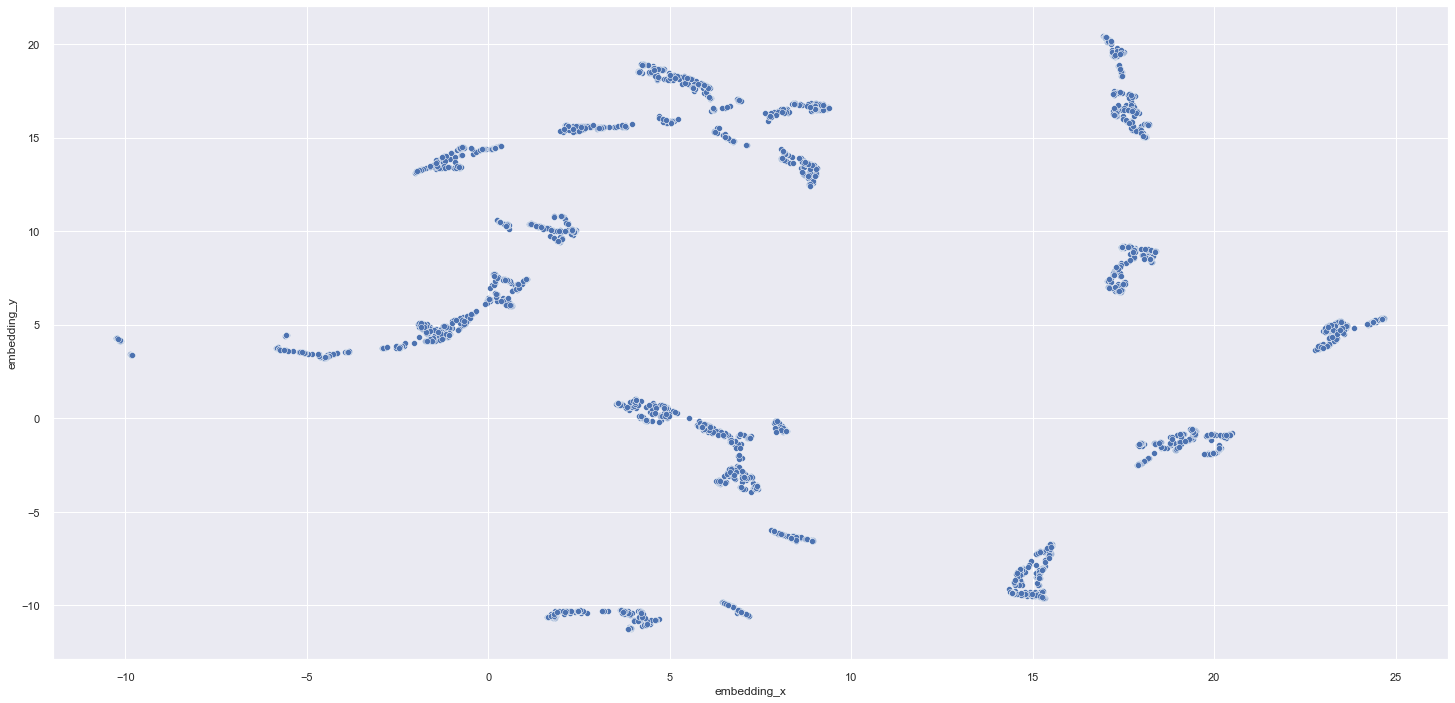

In [134]:
#Reduzir dimensionalidade de 100 para 2 e ser possível visualizar 
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)



- Desta forma perde-se a explicabilidade em relação às variáveis originais. Ex: explicar pq um ponto é vizinho considerando as variáveis. Caso o time de négocio não se importe, tá ok. 

# 5.0 Data Preparation

In [46]:
df5 = df4.copy()

In [47]:
df5.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'qtd_invoices',
       'qtd_items', 'qtd_products', 'avg_ticket', 'avg_recency_days',
       'frequency', 'qtd_returns', 'avg_basket_size',
       'avg_unique_basket_size'],
      dtype='object')

In [51]:
ss = pp.MinMaxScaler()

#
df5['gross_revenue']          = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days']           = ss.fit_transform(df5[['recency_days']])
df5['qtd_invoices']           = ss.fit_transform(df5[['qtd_invoices']])
df5['qtd_items']              = ss.fit_transform(df5[['qtd_items']])
df5['qtd_products']           = ss.fit_transform(df5[['qtd_products']])
df5['avg_ticket']             = ss.fit_transform(df5[['avg_ticket']])
df5['avg_recency_days']       = ss.fit_transform(df5[['avg_recency_days']])
df5['frequency']              = ss.fit_transform(df5[['frequency']])
df5['qtd_returns']            = ss.fit_transform(df5[['qtd_returns']])
df5['avg_basket_size']        = ss.fit_transform(df5[['avg_basket_size']])
df5['avg_unique_basket_size'] = ss.fit_transform(df5[['avg_unique_basket_size']])

# 6.0 Feature Selection

In [52]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

In [74]:
df7 = df6.drop(columns=['customer_id'])

In [75]:
df7.head()

,gross_revenue,recency_days,frequency,avg_ticket
0,5391.21,372.0,34.0,18.152222
1,3232.59,56.0,9.0,18.904035
2,6705.38,2.0,15.0,28.902500
3,948.25,95.0,5.0,33.866071
4,876.00,333.0,3.0,292.000000


In [76]:
clusters = [2,3,4,5,6,7]

## 7.1 Within-Cluster Sum of Square (WSS)

In [ ]:
wss = []
for k in clusters:
    #model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit(df7)
    
    #validation
    wss.append(kmeans.inertia_)
    
# plot wss - Elbow Method - Pegar o ponto onde houver maior variação, quebra (3 ou 5) Isso significa que após esses pontos a variação de distancia dentro dos clusteres n está diminuindo muito, então n é o ideal
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square');
plt.title('WSS vs K');

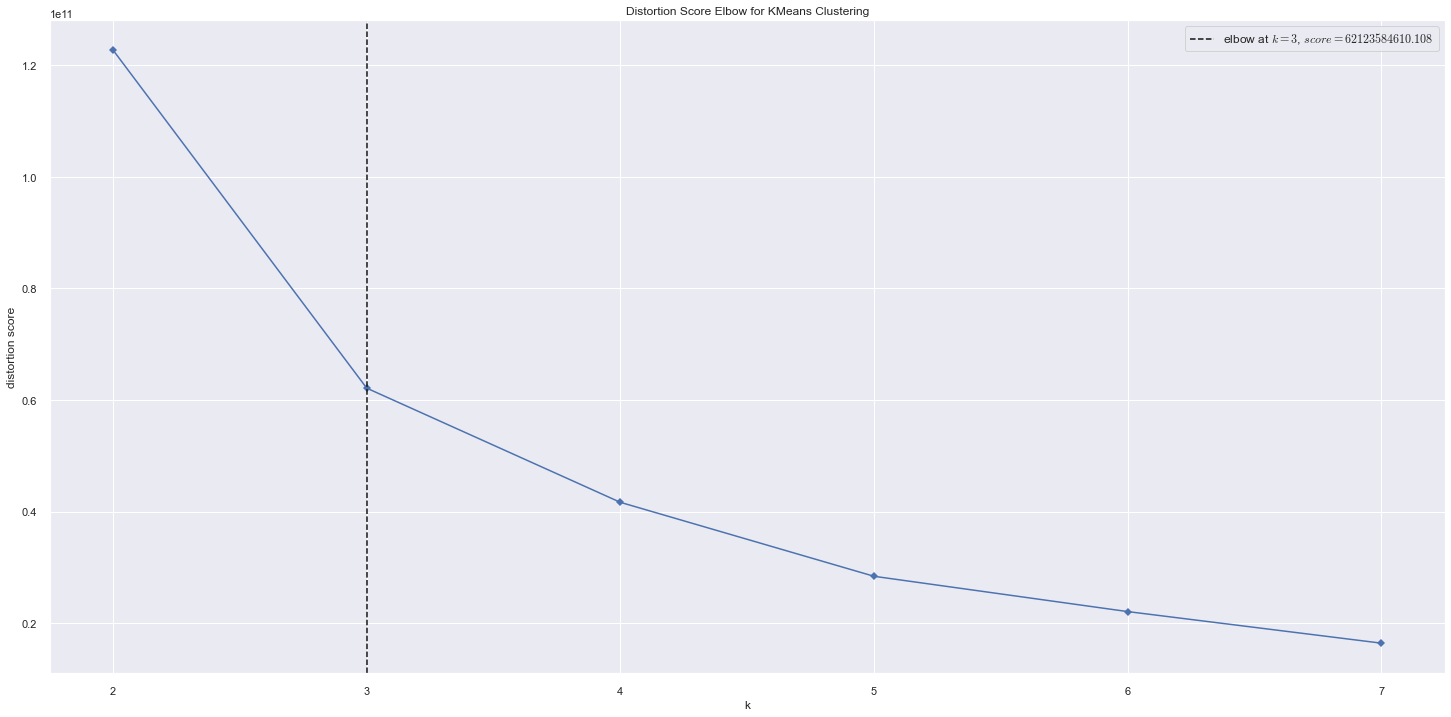

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [77]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(df7)
kmeans.show()

## 7.2 Sillhouette Score (SS)

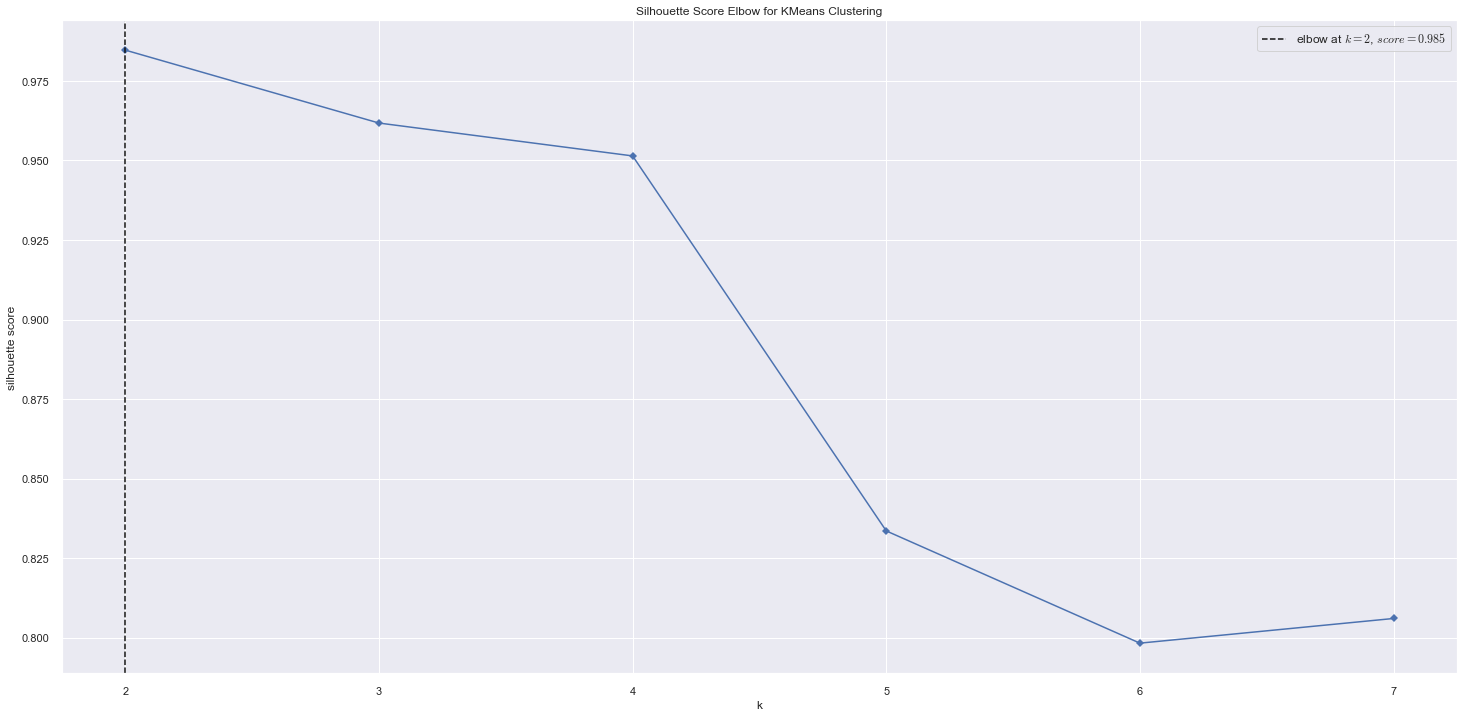

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [78]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(df7)
kmeans.show()

## 7.3 Silhouette Analysis

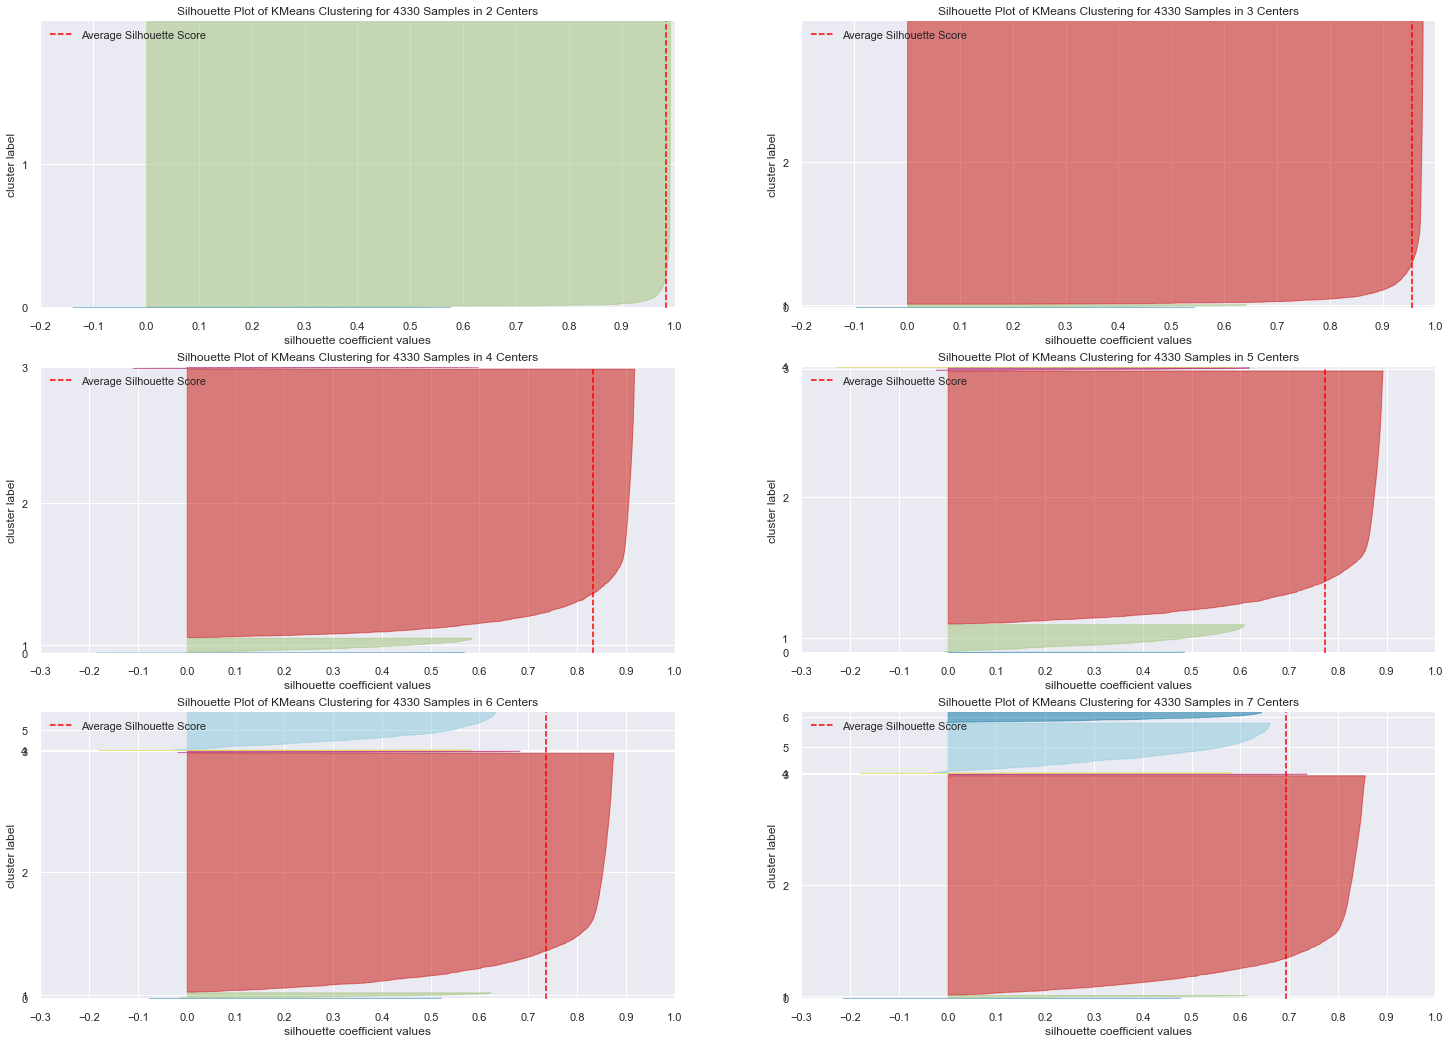

In [79]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2) #Para poder plotar os gráficos. O valor é de acordo com o k mínimo
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df7)
    visualizer.finalize()

In [43]:
df7.head()

,gross_revenue,recency_days,frequency,avg_ticket
0,5288.63,302,35,16.950737
1,3079.10,31,18,15.709694
2,7187.34,2,18,28.634821
3,948.25,95,5,33.866071
4,635.10,330,6,105.850000


# 8.0 Model Training

## 8.1 K-Means

In [80]:
#model definition
k=5
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

#model training
kmeans.fit(df7)

#clustering
labels = kmeans.labels_


### 8.2 Cluster Validation

In [83]:
#WSS
print('WSS value: {}'.format(kmeans.inertia_))

#SS
print(m.silhouette_score(df7, labels, metric='euclidean'))

WSS value: 37802566787.37713
0.7732515336579786


# 9.0 Cluster Analysis

In [85]:
df9 = df4.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,cluster
0,17850,5391.21,372.0,34.0,18.152222,1
1,13047,3232.59,56.0,9.0,18.904035,2
2,12583,6705.38,2.0,15.0,28.902500,1
3,13748,948.25,95.0,5.0,33.866071,2
4,15100,876.00,333.0,3.0,292.000000,2


## 9.1 Visualization Inspection

C:\Users\Ed\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


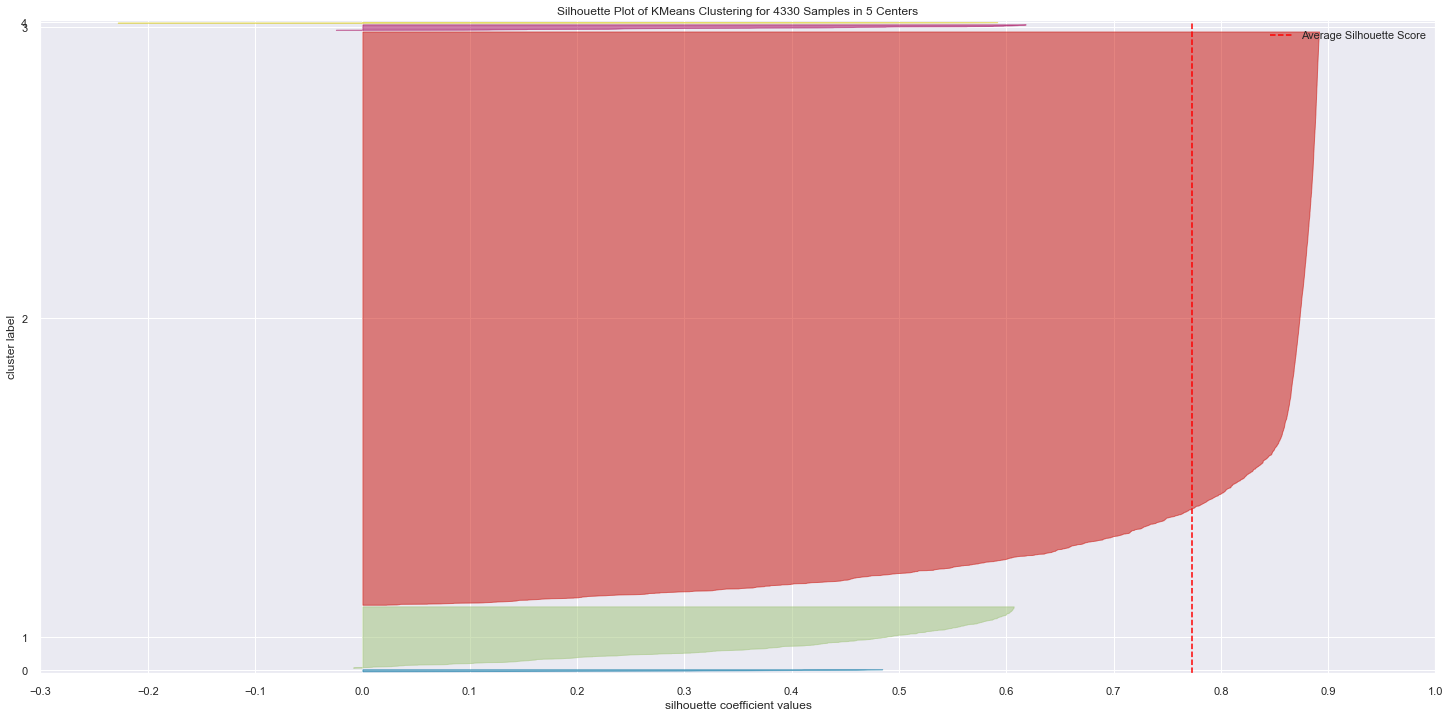

In [86]:
#fig = px.scatter_3d(df9, x='recency_days', y='frequency', z='gross_revenue', color='cluster')
#fig.show()

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df7)
visualizer.finalize()

## 9.3 2d plot

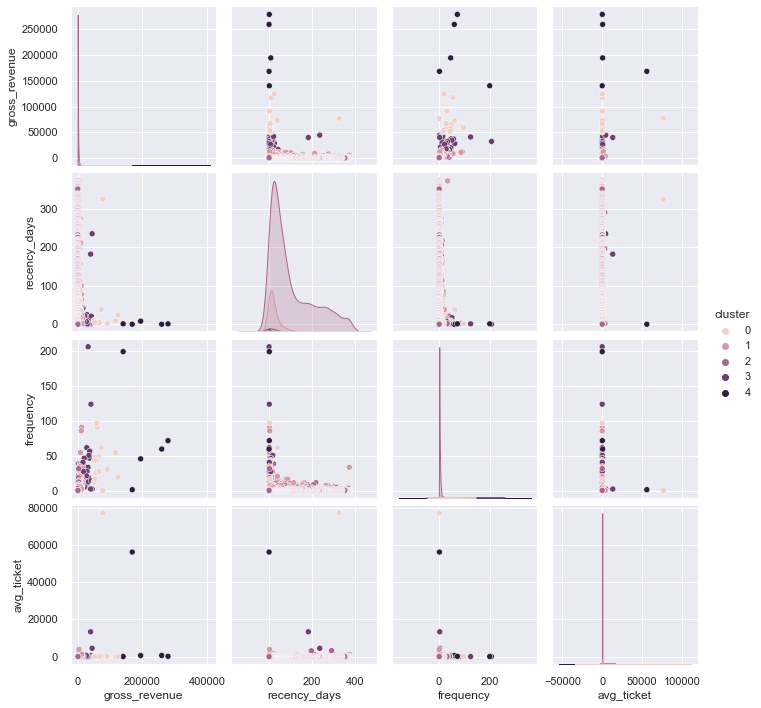

In [87]:
df_viz = df9.drop(columns='customer_id', axis = 1)
sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP - t-SNE

#PCA - Matrix, Espaço de Distância - Espaço Hilbert - 9 condições - Colorários
#UMAP, t-SNE - Manifold - Topologia - Ferramentas que fazem a projeção de alta dimensão para baixa dimensão.




<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

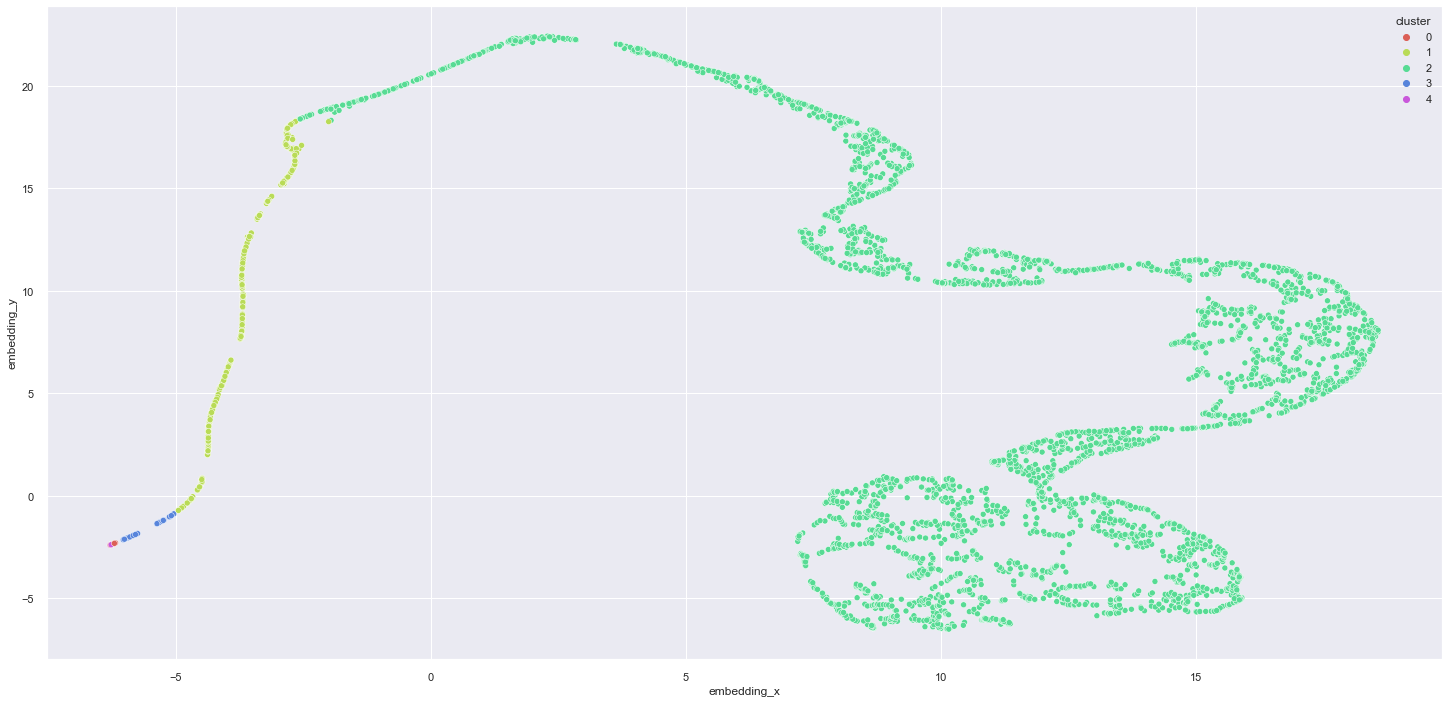

In [88]:
reducer = umap.UMAP(random_state=42) #UMAP é melhor para muitos dados pq executa mais rápido. t-SNE é mais robusto, tem melhor resultado, mas demora.
embedding = reducer.fit_transform(df7)

#embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz)

#Os pontos próximos devem ter a mesma cor
#Encontra a similaridade entre os vizinhos e faz a projeção num espaço menor

In [32]:
df9.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,3
1,13047,3079.10,31,18,15.709694,0
2,12583,7187.34,2,18,28.634821,3
3,13748,948.25,95,5,33.866071,0
4,15100,635.10,330,6,105.850000,0


## 9.4 Cluster Profile

In [89]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

#AVG Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

#AVG Recency
df_avg_recency = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

#AVG Frequency
df_avg_frequency = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how='inner', on='cluster')

#AVG_Ticket
df_avg_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner', on='cluster')


In [90]:
df_cluster.head()

,cluster,customer_id,perc_customer,gross_revenue,recency_days,frequency,avg_ticket
0,0,15,0.346420,70563.601333,29.333333,41.800000,5319.257814
1,1,413,9.538106,5932.363584,26.193705,12.377724,60.568214
2,2,3859,89.122402,843.890329,100.341798,2.847370,28.490561
3,3,38,0.877598,25177.080000,17.789474,34.184211,585.440059
4,4,5,0.115473,208453.866000,2.000000,75.800000,11499.503365


### Cluster 01: (Candidato à Insider)
    - Número de customers: 6 (0.2% dos customers)
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $182.182,00 dólares
        
### Cluster 02: 
    - Número de customers: 31 (0.8% dos customers)
    - Recência em média: 14 dias
    - Compras em média:53 compras
    - Receita em média: $40.543,52 dólares
        
### Cluster 03: 
    - Número de customers: 4.335 (99% dos customers)
    - Recência em média: 92 dias
    - Compras em média:5 compras
    - Receita em média: $1.372,57 dólares

# 10.0 Deploy To Production